In [1]:
import pandas as pd
import numpy as np
import datetime
from pandas.tseries.offsets import *

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import *
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn import *
from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor
import pickle
from lunar import *

%matplotlib inline

/home/yuanhao/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/yuanhao/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/home/yuanhao/anaconda3/lib/python3.6/site-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWar

In [27]:
s = Solar(2014,1,1)
cvt = LunarSolarConverter()
l = cvt.SolarToLunar(s)
print(l.lunarYear, l.lunarMonth, l.lunarDay)

2013 12 1


In [28]:
df_origin = pd.read_table('train_20171215.txt',encoding='gbk',sep='\t')

In [29]:
df.head()

,date,day_of_week,brand_x,cnt_x,day_of_week_x,brand_y,cnt_y,day_of_week_y,gap,virtual_date,...,h_month,h_type,month,year,week,day,xun,lunar_month,lunar_day,lunar_year
0,1,3,1,20,3,1,20,3,1,2014-01-01,...,2,1.0,1,2014,1,1,0,12,1,2013
1,1,3,1,20,3,5,48,3,1,2014-01-01,...,2,1.0,1,2014,1,1,0,12,1,2013
2,1,3,5,48,3,1,20,3,1,2014-01-01,...,2,1.0,1,2014,1,1,0,12,1,2013
3,1,3,5,48,3,5,48,3,1,2014-01-01,...,2,1.0,1,2014,1,1,0,12,1,2013
4,2,4,1,16,4,1,16,4,1,2014-01-02,...,2,1.0,1,2014,1,2,0,12,2,2013


In [30]:
df=pd.DataFrame(df_origin[['date','cnt','day_of_week']].groupby(['date','day_of_week']).cnt.agg('sum').reset_index())

In [31]:
df['gap']=0

In [32]:
for idx, row in df.iterrows():
    if idx==0:
        row['gap']=1
        continue
    row['gap']=row['day_of_week']-df.iloc[idx-1,:]['day_of_week']
    while row['gap']<=0:
        row['gap']+=7

In [33]:
df['virtual_date']=pd.NaT

In [34]:
for idx, row in df.iterrows():
    if idx==0:
        d=datetime.date(2014,1,1)
        while d.weekday()!=df.loc[idx,'day_of_week']-1:
            d += DateOffset(days=1)
        df.loc[idx, 'virtual_date']=d
        continue
    df.loc[idx, 'virtual_date']=df.loc[idx-1,'virtual_date']+DateOffset(days=row['gap'])


In [35]:
# get all the holidays
holidays={'date':[],
          'length':[]}
for idx, row in df.iterrows():
    if row['gap']>2:
        holidays['length'].append(row['gap'])
        holidays['date'].append(row['virtual_date']+DateOffset(days=-(row['gap']//2)))
# convert to DataFrame
holidays_df = pd.DataFrame(holidays, columns=['date','length'])

# get holiday features
df['h_distance'] = 100
df['h_length'] = 0
df['h_month'] = 0
df['h_type']=np.nan
for idx, row in df.iterrows():
    delta = holidays_df['date']-row['virtual_date']
    nearest_idx = delta.abs().values.argmin()
    df.loc[idx, 'h_distance'] = delta[nearest_idx].days
    df.loc[idx, 'h_length'] = holidays_df.loc[nearest_idx, 'length']
    df.loc[idx, 'h_month'] = holidays_df.loc[nearest_idx, 'date'].month
    if df.loc[idx, 'h_month'] in [1,2]:
        df.loc[idx, 'h_type'] = 1
    elif df.loc[idx, 'h_month'] in [9,10]:
        df.loc[idx, 'h_type'] = 2
    else:
        df.loc[idx, 'h_type'] = 0

In [36]:
df['month']=df['virtual_date'].dt.month
df['year']=df['virtual_date'].dt.year
df['week']=df['virtual_date'].dt.week
df['day']=df['virtual_date'].dt.day
# df['doy']=df['virtual_date'].dt.dayofyear
df['xun'] = df['day'].apply(lambda x: x//7)

In [37]:
df['lunar_month']=df['virtual_date'].apply(lambda x: cvt.SolarToLunar(Solar(x.year,x.month,x.day)).lunarMonth)
df['lunar_day']=df['virtual_date'].apply(lambda x: cvt.SolarToLunar(Solar(x.year,x.month,x.day)).lunarDay)
df['lunar_year']=df['virtual_date'].apply(lambda x: cvt.SolarToLunar(Solar(x.year,x.month,x.day)).lunarYear)

In [46]:
df.columns

Index(['date', 'day_of_week_x', 'brand', 'cnt', 'day_of_week_y', 'gap',
       'virtual_date', 'h_distance', 'h_length', 'h_month', 'h_type', 'month',
       'year', 'week', 'day', 'xun', 'lunar_month', 'lunar_day', 'lunar_year',
       'last_solar_year_avg', 'last_lunar_year_avg'],
      dtype='object')

In [39]:
df2 = df.drop('cnt', axis=1)

In [40]:
df = df_origin.merge(df2, on=['date'])

In [42]:
solar_cols = ['cnt','month','year','brand']
lunar_cols = ['cnt','lunar_month','lunar_year','brand']
solar_history = pd.DataFrame(df[solar_cols].groupby(['brand','month','year']).cnt.agg('sum'))
solar_history_count = pd.DataFrame(df[solar_cols].groupby(['brand','month','year']).count())

lunar_history = pd.DataFrame(df[lunar_cols].groupby(['brand','lunar_month', 'lunar_year']).cnt.agg('sum'))
lunar_history_count = pd.DataFrame(df[lunar_cols].groupby(['brand','lunar_month', 'lunar_year']).count())

In [44]:
df['last_solar_year_avg']=np.nan
df['last_lunar_year_avg']=np.nan
for idx, row in df.iterrows():
    b = row['brand']
    year, month = row['year']-1, row['month']
    l_year, l_month = row['lunar_year']-1, row['lunar_month']
    s = solar_history.loc[b]
    s_count = solar_history_count.loc[b]
    l = lunar_history.loc[b]
    l_count = lunar_history_count.loc[b]
    if year in s.loc[month].index:
        df.loc[idx, 'last_solar_year_avg']= (s.loc[month].loc[year]/s_count.loc[month].loc[year])[0]
    if l_year in l.loc[l_month].index:
        df.loc[idx, 'last_lunar_year_avg']= (l.loc[l_month].loc[l_year]/l_count.loc[l_month].loc[l_year])[0]    

In [97]:
train_df = df.iloc[0:int(0.8*df.shape[0]),:].drop(['virtual_date','date'], axis=1)
# train_df['virtual_date']=(train_df['virtual_date']-datetime.date(2014,1,1)).apply(lambda x: x.days)
validation_df = df.iloc[int(0.8*df.shape[0]):,:].drop(['virtual_date','date'], axis=1)
# validation_df['virtual_date']=(validation_df['virtual_date']-datetime.date(2014,1,1)).apply(lambda x: x.days)
train_X = train_df.drop(['cnt','year','lunar_year'], axis=1)
train_Y = train_df['cnt']

In [98]:
test_X = validation_df.drop(['cnt','year','lunar_year'], axis=1)
test_Y = validation_df['cnt'] 

In [99]:
train_X.head()

,day_of_week_x,brand,day_of_week_y,gap,h_distance,h_length,h_month,h_type,month,week,day,xun,lunar_month,lunar_day,last_solar_year_avg,last_lunar_year_avg
0,3,1,3,1,40,6,2,1.0,1,1,1,0,12,1,NaN,NaN
1,3,5,3,1,40,6,2,1.0,1,1,1,0,12,1,NaN,NaN
2,4,1,4,1,39,6,2,1.0,1,1,2,0,12,2,NaN,NaN
3,4,3,4,1,39,6,2,1.0,1,1,2,0,12,2,NaN,NaN
4,5,1,5,1,38,6,2,1.0,1,1,3,0,12,3,NaN,NaN


In [100]:
knn_cols = ['day_of_week', 'h_distance', 'h_length', 'h_month', 'month','lunar_month',
            'last_solar_year_avg', 'last_lunar_year_avg']

In [101]:
train_X[['last_solar_year_avg','last_lunar_year_avg']] = train_X[['last_solar_year_avg','last_lunar_year_avg']].fillna(train_X[['last_solar_year_avg','last_lunar_year_avg']].median())

In [234]:
predict = 0
bagging_num = 1
for i in range(bagging_num):
    model1 = ensemble.ExtraTreesRegressor(n_jobs=-1, n_estimators=2000, max_depth=10, max_features=0.8,
                                           min_samples_split = 5, random_state = i*3)
    model1.fit(train_X.fillna(-1), train_Y)
    predict +=  0.4*model1.predict(test_X.fillna(-1))
    
    model1 = LGBMRegressor(boosting_type='gbdt',learning_rate=0.011, n_estimators=1500, subsample=0.7, num_leaves=60+i*5, 
                           colsample_bytree=0.5, random_seed = i*3)
    model1.fit(train_X.fillna(-1), train_Y, categorical_feature=['brand'])
    predict +=  model1.predict(test_X.fillna(-1))

    model1 = CatBoostRegressor(iterations=1500, learning_rate=0.04, depth=6, l2_leaf_reg=2, loss_function='RMSE', 
                           eval_metric='RMSE', logging_level='Silent', random_seed=i*5)
    model1.fit(train_X.fillna(-1), train_Y,cat_features=[1,6,7,8])
    predict += 1.5*model1.predict(test_X.fillna(-1))

#     model1 = KNeighborsRegressor(n_jobs=-1, n_neighbors=20)
#     model1 = LinearRegression(n_jobs=-1)
#     model1.fit(train_X.fillna(-1), train_Y)
#     predict += 0.2*model1.predict(test_X.fillna(-1))
predict = predict/bagging_num/2.9


/home/yuanhao/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1029: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['brand']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [235]:
df.columns

Index(['date', 'day_of_week_x', 'brand', 'cnt', 'day_of_week_y', 'gap',
       'virtual_date', 'h_distance', 'h_length', 'h_month', 'h_type', 'month',
       'year', 'week', 'day', 'xun', 'lunar_month', 'lunar_day', 'lunar_year',
       'last_solar_year_avg', 'last_lunar_year_avg'],
      dtype='object')

In [236]:
predict_df = pd.DataFrame()
predict_df['date'] = df.iloc[int(0.8*df.shape[0]):,6]
predict_df['y'] = predict
predict_sum = predict_df.groupby(['date']).y.agg('sum')

In [237]:
testy_df = pd.DataFrame()
testy_df['date'] = df.iloc[int(0.8*df.shape[0]):,6]
testy_df['y'] = test_Y
testy_sum = testy_df.groupby(['date']).y.agg('sum')

In [238]:
error = predict_sum.values-testy_sum.values
metric= np.mean(np.square(error))
print(metric)

379033.413423


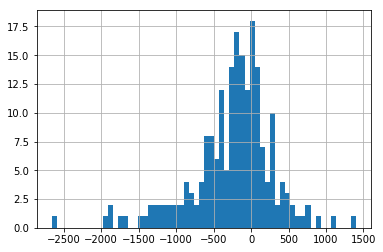

In [130]:
pd.Series(error).hist(bins=60)

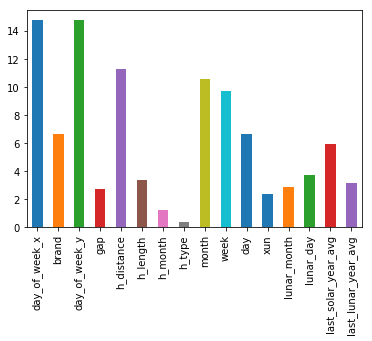

In [131]:
pd.Series(model1.feature_importances_, index = train_X.columns).plot.bar()

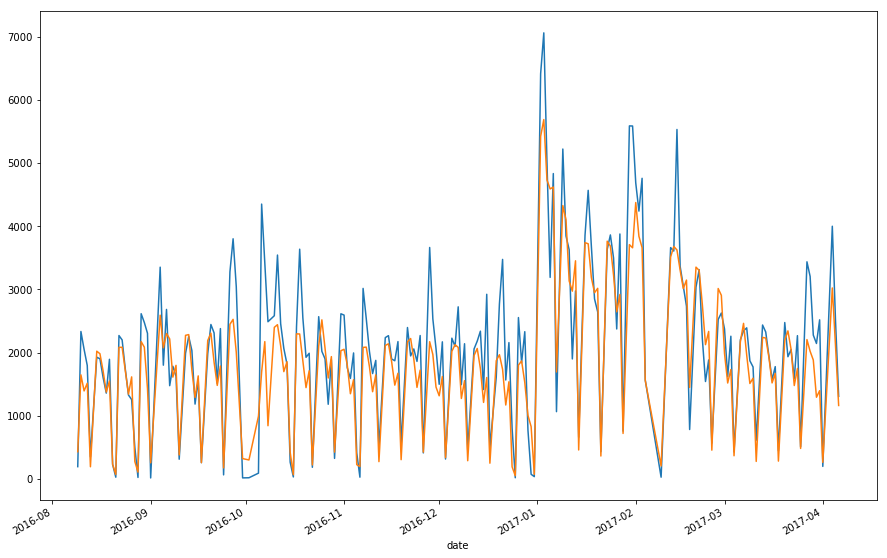

In [132]:
pd.Series(testy_sum).plot(figsize=(15,10))
pd.Series(predict_sum).plot(figsize=(15,10))

In [239]:
whole_df = pd.DataFrame()
for b in range(1,6):
    
    train_X_b = train_X[train_X['brand']==b]
    test_X_b = test_X[test_X['brand']==b]
    train_Y_b = train_Y[train_X['brand']==b]

    predict = 0
    bagging_num = 1
    for i in range(bagging_num):
        model1 = ensemble.ExtraTreesRegressor(n_jobs=-1, n_estimators=2000, max_depth=9, max_features=0.8,
                                               min_samples_split = 4, random_state = i*3)
        model1.fit(train_X_b.fillna(-1), train_Y_b)
        predict +=  0.4*model1.predict(test_X_b.fillna(-1))

        model1 = LGBMRegressor(learning_rate=0.011, n_estimators=1600, subsample=0.7, num_leaves=55+i*5, 
                               colsample_bytree=0.6, random_seed = i*3)
        model1.fit(train_X_b.fillna(-1), train_Y_b)
        predict +=  model1.predict(test_X_b.fillna(-1))

        model1 = CatBoostRegressor(iterations=1500, learning_rate=0.04, depth=8, l2_leaf_reg=2, loss_function='RMSE', 
                               eval_metric='RMSE', logging_level='Silent', random_seed=i*5)
        model1.fit(train_X_b.fillna(-1), train_Y_b, cat_features=[6,7,8])
        predict += 1.5*model1.predict(test_X_b.fillna(-1))

    predict = predict/bagging_num/2.9
    
    predict_df = pd.DataFrame()
    predict_df['date'] = df.loc[test_X_b.index,'virtual_date']
    predict_df['y'] = predict
    whole_df = pd.concat([whole_df, predict_df])


In [240]:
predict_sum = whole_df.groupby(['date']).y.agg('sum')

In [241]:
error = predict_sum.values-testy_sum.values
metric= np.mean(np.square(error))
print(metric)

401963.21609


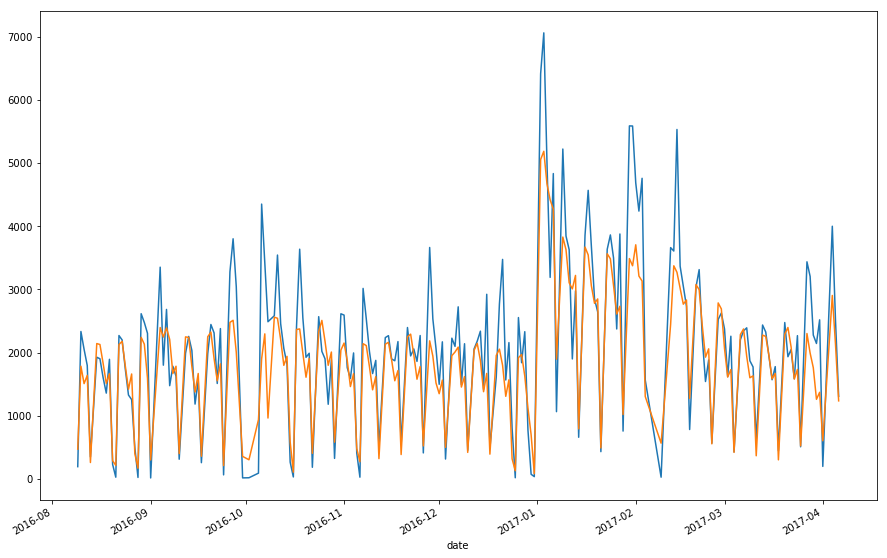

In [242]:
pd.Series(testy_sum).plot(figsize=(15,10))
pd.Series(predict_sum).plot(figsize=(15,10))

In [214]:
train_X_b.head()

,day_of_week_x,brand,day_of_week_y,gap,h_distance,h_length,h_month,h_type,month,week,day,xun,lunar_month,lunar_day,last_solar_year_avg,last_lunar_year_avg
1,3,5,3,1,40,6,2,1.0,1,1,1,0,12,1,317.5,319.346154
8,5,5,5,1,38,6,2,1.0,1,1,3,0,12,3,317.5,319.346154
13,6,5,6,1,37,6,2,1.0,1,1,4,0,12,4,317.5,319.346154
18,7,5,7,1,36,6,2,1.0,1,1,5,0,12,5,317.5,319.346154
23,1,5,1,1,35,6,2,1.0,1,2,6,0,12,6,317.5,319.346154
